# PyTorch: Can we speed up training by initialising the output layer bias?

When training a model we typically see fast improvements in our loss function within the first few epochs before it slows down.
If we set the bias of the output layer directly to the mean of our dataset target, does this behaviour change?

## Create data

We create random data from a binary classification problem. Then we convert to PyTorch dataloaders for training our models.

In [1]:
import torch
import numpy as np
import scipy.special

n = 1_000  # number of data points
m = 4  # number of features

torch.manual_seed(0)
random = np.random.default_rng(seed=0)
w = random.normal(size=(m, 1))  # weights vector
b = random.normal(size=1)
X = random.normal(size=(n, m))
y_logit = b + np.dot(X, w) + random.normal(scale=0.0, size=(n, 1))
y = random.binomial(n=1, p=scipy.special.expit(y_logit)).flatten()

# split to train/test
X_train, X_test, y_train, y_test = (
    X[: int(n / 2)],
    X[int(n / 2) :],
    y[: int(n / 2)],
    y[int(n / 2) :],
)

train_dataset = torch.utils.data.TensorDataset(
    torch.Tensor(X_train), torch.Tensor(y_train)
)
test_dataset = torch.utils.data.TensorDataset(
    torch.Tensor(X_test), torch.Tensor(y_test)
)

# create to data loader
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=int(n / 2), shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=int(n / 2), shuffle=False
)


## Build models

The model we build is a binary classifier with a single linear layer, a logistic regression, to match our data generating process. We set the criterion to `BCEWithLogitsLoss`. Given we have 4 features, there are only 5 parameters to learn here. We set the seed to ensure that the weights are initialised to the same values. We train the model for 50 epochs and time how long it takes.

In [2]:
import pytorch_lightning as pl
import torch.nn as nn

models = {}


class BCEModel(pl.LightningModule):
    def __init__(self, input_features: int, learning_rate=0.01, output_bias=None):
        super().__init__()

        torch.manual_seed(0)
        self.classifier = nn.Linear(input_features, 1)

        if output_bias is not None:
            self.classifier.bias.data.fill_(output_bias)

        # Define loss function
        self.criterion = nn.BCEWithLogitsLoss()

        # Define optimizer
        self.learning_rate = learning_rate
        self.optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate)

        # training logs
        self.log_bias = []
        self.log_weights = []
        self.log_train = []
        self.log_val = []

    def forward(self, x):
        x = self.classifier(x)
        return x.flatten()

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("train_loss", loss, prog_bar=True, on_step=True)
        self.log_train.append(loss.detach().cpu().numpy())

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("val_loss", loss, prog_bar=True, on_step=True)
        self.log_val.append(loss.cpu().numpy())

        self.log_bias.append(self.classifier.bias[0].detach().cpu().numpy())
        self.log_weights.append(self.classifier.weight.data.detach().cpu().numpy())

    def configure_optimizers(self):
        return self.optimizer


/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Default initialisation

The first model we train will use the default initialisation.

In [3]:
models["default_init"] = BCEModel(learning_rate=5e-1, input_features=m)
trainer = pl.Trainer(max_epochs=50, enable_progress_bar=True, accelerator="gpu")
trainer.fit(models["default_init"], train_loader, test_loader)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type              | Params
-------------------------------------------------
0 | classifier | Linear            | 5     
1 | criterion  | BCEWithLogitsLoss | 0     
-------------------------------------------------
5         Trainable params
0         Non-trainable params
5         Total params
0.000     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 37.29it/s, v_num=2, train_loss=0.604, val_loss_step=0.568, val_loss_epoch=0.568] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 33.93it/s, v_num=2, train_loss=0.604, val_loss_step=0.568, val_loss_epoch=0.568]


## Initialising with the target mean

Now we train the same model but initialise the output layer bias to the mean of the target mean.
We need to convert the mean to logits as the model outputs logits not probabilities.

In [4]:
output_bias = torch.special.logit(torch.tensor(y_train.mean()))

models["target_mean"] = BCEModel(
    learning_rate=5e-1, input_features=m, output_bias=output_bias
)
trainer = pl.Trainer(max_epochs=50, enable_progress_bar=True, accelerator="gpu")
trainer.fit(models["target_mean"], train_loader, test_loader)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type              | Params
-------------------------------------------------
0 | classifier | Linear            | 5     
1 | criterion  | BCEWithLogitsLoss | 0     
-------------------------------------------------
5         Trainable params
0         Non-trainable params
5         Total params
0.000     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s, v_num=3, train_loss=0.604, val_loss_step=0.568, val_loss_epoch=0.568] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 16.10it/s, v_num=3, train_loss=0.604, val_loss_step=0.568, val_loss_epoch=0.568]


## Plot training performance

We see that the model with the target mean as the output bias has slightly better initial performance, but this doesn't affect converged performance.

/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_90456/2805564013.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")
/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_90456/2805564013.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


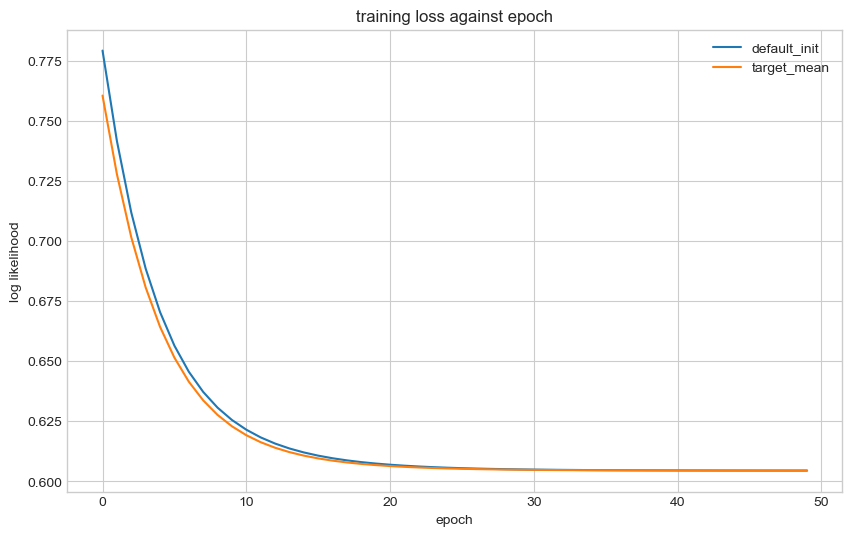

In [5]:
import matplotlib.pyplot as plt

plt.style.use("seaborn-whitegrid")

fig, ax = plt.subplots(figsize=(10, 6))
for name, _model in models.items():
    ax.plot(_model.log_train, label=name)
ax.set(title="training loss against epoch", xlabel="epoch", ylabel="log likelihood")
ax.legend()
fig.show()


## Plot bias and weights trajectories

For the default initialised model, the bias changes a lot in the first epochs, whereas the model initialised with the target mean doesnt need to:

/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_90456/742196672.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


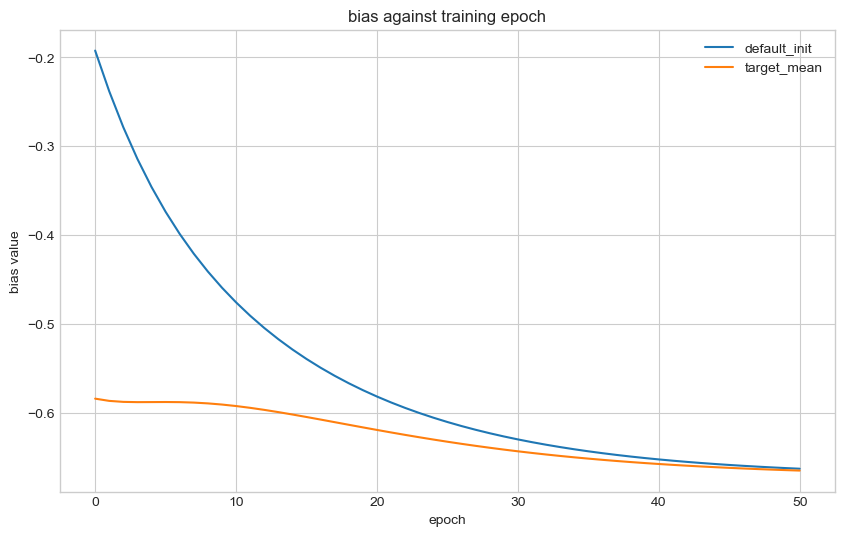

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))
for name, _model in models.items():
    ax.plot(_model.log_bias, label=name)
ax.set(title="bias against training epoch", xlabel="epoch", ylabel="bias value")
ax.legend()
fig.show()


The weights trajectories look somewhat similar between the different initialisations:

/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_90456/597744698.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


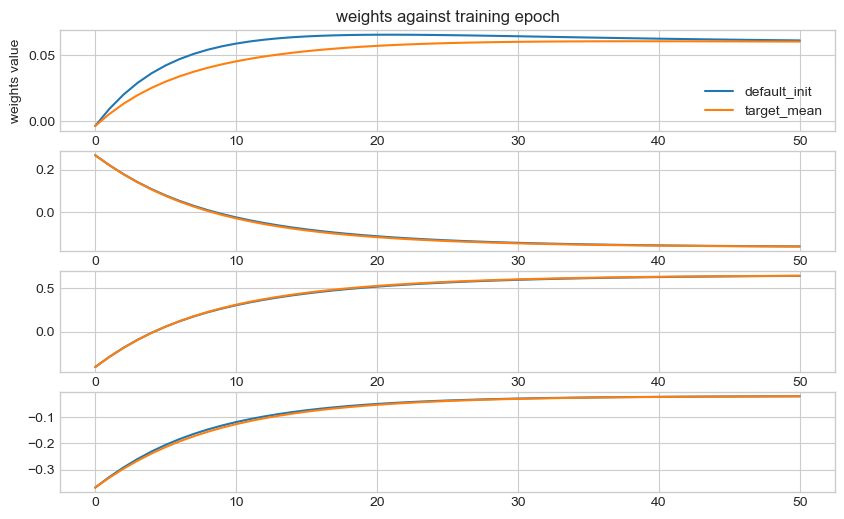

In [7]:
fig, ax = plt.subplots(figsize=(10, 6), nrows=m)
for name, _model in models.items():
    _model_weights = np.array(_model.log_weights).squeeze()
    for _m in range(m):
        ax[_m].plot(_model_weights[:, _m], label=name)
ax[0].set(
    title=f"weights against training epoch", xlabel="epoch", ylabel="weights value"
)
ax[0].legend()
fig.show()


## Conclusions

This effect is likely less pronouced with other optimisation methods, such as ADAM, where these require the first iterations to estimate momentum of gradients.